In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image
from torchvision.transforms import ToTensor

# Setup Path
current_dir = Path(os.getcwd())
project_root = current_dir.parent
sys.path.append(str(project_root))

from src.train.model import Generator

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def load_model(epoch):
    model = Generator(upscale_factor=2).to(device)
    ckpt_path = project_root / "outputs" / "checkpoints" / f"checkpoint_epoch_{epoch}.pth"
    
    if not ckpt_path.exists():
        print(f"Warning: Checkpoint epoch {epoch} not found!")
        return None
        
    checkpoint = torch.load(ckpt_path, map_location=device)
    if 'G_state' in checkpoint:
        model.load_state_dict(checkpoint['G_state'])
    else:
        model.load_state_dict(checkpoint)
    
    model.eval()
    return model

# Load Model Epoch 12 (Best PSNR) & Epoch 35 (Best Visual)
model_psnr = load_model(12) 
model_gan = load_model(35)

In [3]:
def inference(model, lr_tensor):
    if model is None: return None
    with torch.no_grad():
        sr_t = model(lr_tensor)
    return (sr_t.squeeze(0).cpu().clamp(-1, 1) + 1) / 2

def plot_comparison_paper_style(img_path, crops_coords):
    """
    img_path: Path to image
    crops_coords: List of (x, y, size, color) tuples. Example: [(100,100,80,'red'), (200,200,80,'yellow')]
    """
    # 1. Prepare Images
    hr = Image.open(img_path).convert("RGB")
    w, h = hr.size
    # Crop to fit scale factor
    new_w, new_h = w - (w % 2), h - (h % 2)
    hr = hr.resize((new_w, new_h), Image.BICUBIC)
    
    # Generate LR
    lr = hr.resize((new_w // 2, new_h // 2), Image.BICUBIC)
    
    # Generate Bicubic Upscale
    bicubic = lr.resize((new_w, new_h), Image.BICUBIC)
    
    # Prepare Input Tensor
    lr_t = ToTensor()(lr).unsqueeze(0).to(device) * 2 - 1
    
    # Generate SRGAN Outputs
    sr_psnr_t = inference(model_psnr, lr_t)
    sr_gan_t = inference(model_gan, lr_t)
    
    # Convert to PIL
    to_pil = lambda t: Image.fromarray((t.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    
    sr_psnr = to_pil(sr_psnr_t) if sr_psnr_t is not None else bicubic
    sr_gan = to_pil(sr_gan_t) if sr_gan_t is not None else bicubic
    
    images = [bicubic, sr_psnr, sr_gan, hr]
    titles = ["Bicubic", "SRGAN (Ep 12)\nHigh PSNR", "SRGAN (Ep 35)\nBest Visual", "Original HR"]
    
    # 2. Setup Plot Layout
    num_cols = 4
    num_rows = 1 + len(crops_coords) # 1 Row for Full Image + N Rows for Crops
    
    fig = plt.figure(figsize=(16, 4 * num_rows))
    gs = fig.add_gridspec(num_rows, num_cols, hspace=0.1, wspace=0.1)
    
    # 3. Plot Full Images (Top Row)
    for col, img in enumerate(images):
        ax = fig.add_subplot(gs[0, col])
        ax.imshow(img)
        ax.set_title(titles[col], fontsize=14, fontweight='bold', pad=10)
        ax.axis('off')
        
        # Draw Rectangles on Full Image
        for (x, y, size, color) in crops_coords:
            rect = patches.Rectangle((x, y), size, size, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

    # 4. Plot Crops (Bottom Rows)
    for row_idx, (x, y, size, color) in enumerate(crops_coords):
        for col, img in enumerate(images):
            # Crop Image
            crop = img.crop((x, y, x + size, y + size))
            
            # Plot
            ax = fig.add_subplot(gs[row_idx + 1, col])
            ax.imshow(crop)
            
            # Add colored border to the subplot to match the box above
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3)
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Label only on the first column
            if col == 0:
                ax.set_ylabel(f"Crop {row_idx+1}", fontsize=12, fontweight='bold', color=color)

    plt.tight_layout()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11932\963060870.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


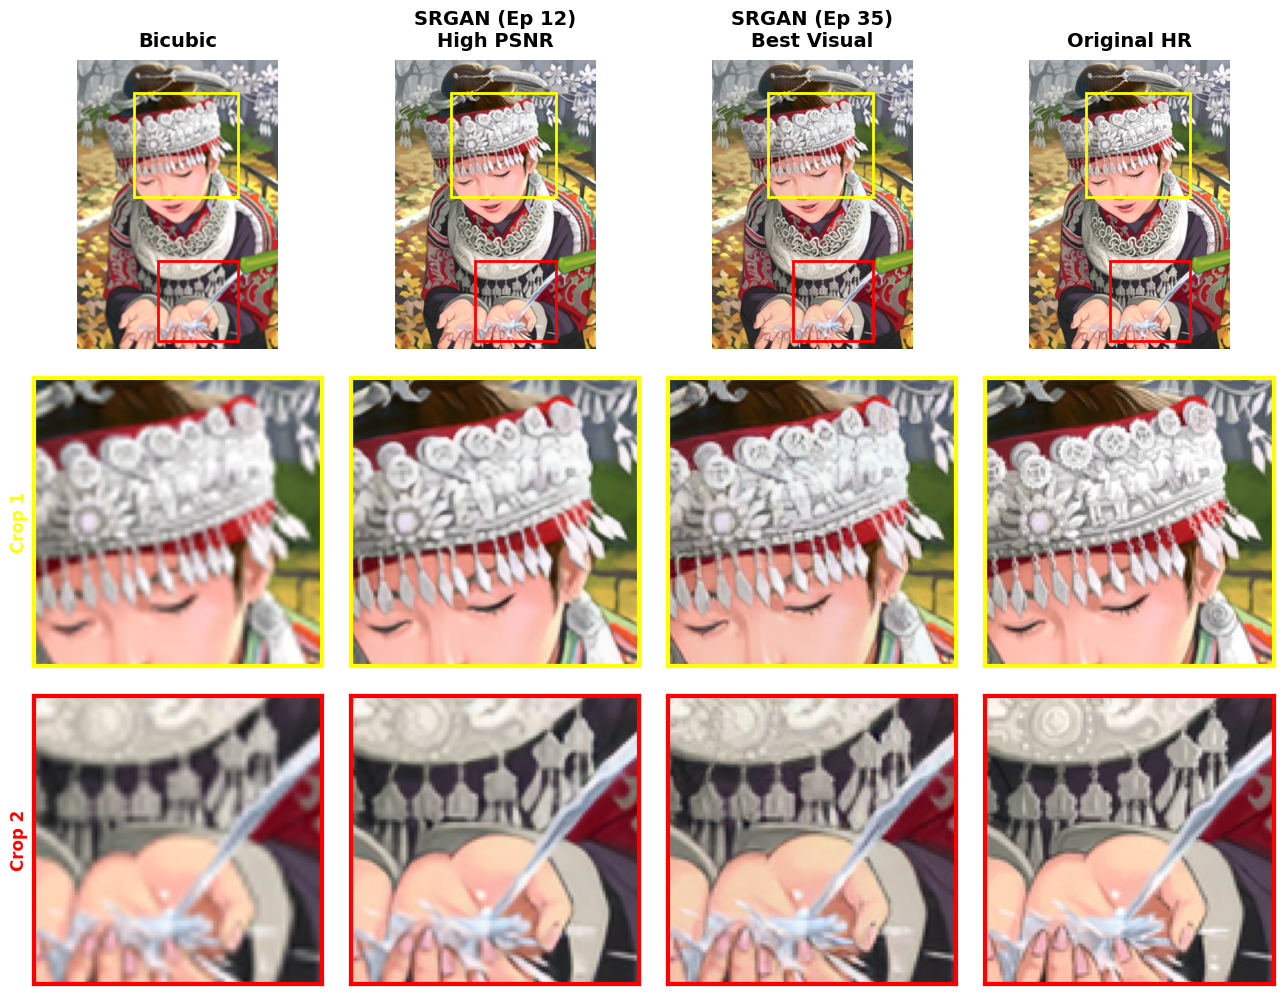

In [ ]:
test_image = project_root / "data" / "custom" / "Set14" / "comic.png"

crops = [
    (70, 40, 130, 'yellow'),    
    (100, 250, 100, 'red') 
]

if test_image.exists():
    plot_comparison_paper_style(test_image, crops)
else:
    print(f"File not found: {test_image}")
    print("Silakan ganti path di variabel 'test_image'")